Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


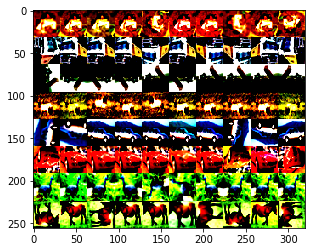

In [0]:
# https://medium.com/@prasad.pai/how-to-use-dataset-and-iterators-in-tensorflow-with-code-samples-3bb98b6b74ab
# https://lambdalabs.com/blog/tensorflow-2-0-tutorial-01-image-classification-basics/
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
def augmentation(image, label):
    crop_w = int(TARGET_SIZE[0]*0.9) 
    crop_h = int(TARGET_SIZE[1]*0.9)
    crop_or_pad_s = int(TARGET_SIZE[0]*0.1) + TARGET_SIZE[0]
    crop_or_pad_p = int(TARGET_SIZE[1]*0.1) + TARGET_SIZE[1]
    image = tf.image.resize_with_crop_or_pad(image, crop_or_pad_s, crop_or_pad_p)
    image = tf.image.random_crop(image, [crop_w, crop_h, 3])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, k=random.randrange(4))
    image = tf.image.random_saturation(image, 0.6, 1.6)
    image = tf.image.random_hue(image, 0.08)
    image = tf.image.random_contrast(image, 0.7, 1.3)
    image = tf.image.random_brightness(image, 0.05)
    return image, label
    
def normalize(image, label):
    image = tf.image.per_image_standardization(image)
    return image, label

dataset = get_training_dataset()
dataset = dataset.map(augmentation)
dataset = dataset.map(normalize)

###############################################################################
#############################################
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))


def transform(image,label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 0.8 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 0.8 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]),label



################################################################################################
###############################
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.enable_eager_execution()
def plot_images(dataset, n_images, samples_per_image):
    output = np.zeros((32 * n_images, 32 * samples_per_image, 3))

    row = 0
    for images in dataset.repeat(samples_per_image).batch(n_images):
        output[:, row*32:(row+1)*32] = np.vstack(images.numpy())
        row += 1

    plt.figure()
    plt.imshow(output)
    plt.show()

def flip(x: tf.Tensor) -> tf.Tensor:
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)

    return x

def color(x: tf.Tensor) -> tf.Tensor:
    x = tf.image.random_hue(x, 0.08)
    x = tf.image.random_saturation(x, 0.6, 1.6)
    x = tf.image.random_brightness(x, 0.05)
    x = tf.image.random_contrast(x, 0.7, 1.3)
    return x

def rotate(x: tf.Tensor) -> tf.Tensor:
    return tf.image.rot90(x, tf.random_uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

def zoom(x: tf.Tensor) -> tf.Tensor:
    # Generate 20 crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(0.8, 1.0, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(48, 48))
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]


    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: x, lambda: random_crop(x))

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

data = (x_train[0:8] / 255).astype(np.float32)
dataset = tf.data.Dataset.from_tensor_slices(data)

# Add augmentations
augmentations = [flip, color, zoom, rotate]
def do_augmentation(dataset, augmentations):
    for f in augmentations:
        dataset = dataset.map(lambda x: tf.cond(tf.random.uniform([], 0, 1) > 0.75, lambda: f(x), lambda: x), num_parallel_calls=4)
    return dataset.map(lambda x: tf.clip_by_value(x, 0, 1))

def normalize(image):
    image = tf.image.per_image_standardization(image)
    return image

dataset = do_augmentation(dataset, augmentations)
dataset = dataset = (dataset.map(normalize))
plot_images(dataset, n_images=8, samples_per_image=10)

